In [1]:
# kernel base python 3.9.12

# import data from 86 files .nc4
- date: 2019-01-01  
  - variables:
    - latitudes
    - longitudes
    - CO2_std
    - CO2_sdev
  - dimensions:
    - time
    - lat
    - lon
  - attributes:
    - year
    - month
    - day
    - time

### Normailize data ???

In [2]:
# import libs
import os
import netCDF4 as nc4
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import itertools
from scipy.stats import norm, shapiro

In [3]:
# Ruta al directorio que contiene los archivos netCDF
directorio_archivos = 'descargas'
# Lista de archivos netCDF en el directorio
archivos_netCDF = [os.path.join(directorio_archivos, nombre_archivo) for nombre_archivo in os.listdir(directorio_archivos) if nombre_archivo.endswith('.nc4')]
# create a dict de dimensiones [91,144]
row = np.arange(0,91)
col = np.arange(0,144)
dict_dim = dict()

def media_armonica(valores):
    inversos = [1 / x for x in valores if x != 0]  # Calcula los inversos de los valores no iguales a 0
    if len(inversos) == 0:
        return 0  # Si no hay valores válidos, devuelve 0
    return len(inversos) / sum(inversos)

for i,j in itertools.product(row,col):
    dict_dim[(i,j)] = {"lat": [], "lon": [], "co2_std": [], "co2_sdev": []}
    # dict_dim[(i,j,"lon")] = []
    # dict_dim[(i,j,"co2_std")] = []
    # dict_dim[(i,j,"co2_sdev")] = []

for i in range(len(archivos_netCDF)):
    # Abre el archivo netCDF
    data = nc4.Dataset(archivos_netCDF[i],"r")

    latitude = data.variables['Latitude'][:]
    longitude = data.variables['Longitude'][:]
    co2_std = data.variables['mole_fraction_of_carbon_dioxide_in_free_troposphere'][:]
    co2_sdev = data.variables['mole_fraction_of_carbon_dioxide_in_free_troposphere_sdev'][:]
    # print(latitude)
    # print(longitude)
    # print(co2_std)
    # print(co2_sdev)
    lon, lat = np.meshgrid(longitude, latitude)

    # Aplana las mallas de coordenadas y la matriz de co2_free_troposphere a vectores unidimensionales
    lon_flat = lon #.flatten()
    lat_flat = lat #.flatten()
    # create data.fream
    df_lat = pd.DataFrame(lat_flat).fillna(0)
    df_lon = pd.DataFrame(lon_flat).fillna(0)
    df_co2_std = pd.DataFrame(co2_std).fillna(0)
    df_co2_sdev = pd.DataFrame(co2_sdev).fillna(0)




    for i,j in itertools.product(row,col):
        aux_lat = df_lat.iloc[i,j]
        dict_dim[(i,j)]["lat"].append(aux_lat)
        dict_dim[(i,j)]["lon"].append(df_lon.iloc[i,j])
        dict_dim[(i,j)]["co2_std"].append(df_co2_std.iloc[i,j])
        dict_dim[(i,j)]["co2_sdev"].append(df_co2_sdev.iloc[i,j])     

# Crear un data frame de los puntos unicos lat, lon para la dimension i,j
        
# print(dict_dim[(0,0)]["lat"])
columns = ["co2_std", "co2_sdev", "lat", "lon"]
df_dim = pd.DataFrame(columns=columns)
glat, glon = [], []
for i,j in itertools.product(row,col):
    # print(dict_dim[(i,j)]["lat"])
    # print(dict_dim[(i,j)]["lon"])
    # print(dict_dim[(i,j)]["co2_std"])
    # print(dict_dim[(i,j)]["co2_sdev"])
    # print("==================================")
    # print("==================================")
    # print("==================================")
    # print("=============================
    x = media_armonica(dict_dim[(i,j)]["co2_sdev"])
    y = media_armonica(dict_dim[(i,j)]["co2_std"])
    #print(pd.Series(dict_dim[(i,j)]["lat"]).unique()[0], pd.Series(dict_dim[(i,j)]["lon"]).unique()[0])
    glat.append(pd.Series(dict_dim[(i,j)]["lat"]).unique()[0]), glon.append(pd.Series(dict_dim[(i,j)]["lon"]).unique()[0])
    min_lat_lon = min([len(pd.Series(dict_dim[(i,j)]["lat"]).unique()),len(pd.Series(dict_dim[(i,j)]["lon"]).unique())])
    if min_lat_lon == 1:
        df_dim.loc[len(glat)-1] = [x, y, pd.Series(dict_dim[(i,j)]["lat"]).unique()[0], pd.Series(dict_dim[(i,j)]["lon"]).unique()[0]]
        # ({"co2_std": x, "co2_sdev": y, "lat": [pd.Series(dict_dim[(i,j)]["lat"]).unique()[0]], "lon": [pd.Series(dict_dim[(i,j)]["lon"]).unique()[0]]})
    else:
        df_dim.loc[len(glat)-1] = [x, y, pd.Series(dict_dim[(i,j)]["lat"]).unique()[0], pd.Series(dict_dim[(i,j)]["lon"]).unique()[0]]
        print("no es unico".upper().ljust(30,"="))
    # print()    
                

    
        # value.append(df_lat.iloc[i,j])
        # value.append(df_lon.iloc[i,j])



In [4]:
df_dim["co2_sdev"]

0        0.000395
1        0.000407
2        0.000401
3        0.000394
4        0.000403
           ...   
13099    0.000000
13100    0.000000
13101    0.000000
13102    0.000000
13103    0.000000
Name: co2_sdev, Length: 13104, dtype: float64

In [5]:
#create a geodataframe with geopandas and shapely: lat, lon -> glat, glon 
#from matplotlib.patches import Polygon
#geometry = [gdp.Polygon(xy) for xy in zip(glon, glat)]
geometry = [Point(xy) for xy in zip(glon, glat)]
crs = 'EPSG:4326'
gdf = gpd.GeoDataFrame(df_dim, crs=crs, geometry=geometry)

In [6]:
min(df_dim["co2_std"]) 
float(max(df_dim["co2_std"]))
df_dim.query("co2_std >= 0.000005")

co2_std  co2_sdev   lat    lon
269  0.000005  0.000396  88.0  132.5

# Analisis Exploratorio

In [7]:
#describe the data
gdf.describe() 

co2_std      co2_sdev           lat           lon
count  13104.000000  13104.000000  13104.000000  13104.000000
mean       0.000002      0.000330     -0.005495     -1.250000
std        0.000001      0.000148     52.528319    103.924508
min        0.000000      0.000000    -90.000000   -180.000000
25%        0.000002      0.000394    -46.000000    -90.625000
50%        0.000003      0.000395      0.000000     -1.250000
75%        0.000003      0.000396     46.000000     88.125000
max        0.000005      0.000419     89.500000    177.500000

In [8]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 13104 entries, 0 to 13103
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   co2_std   13104 non-null  float64 
 1   co2_sdev  13104 non-null  float64 
 2   lat       13104 non-null  float64 
 3   lon       13104 non-null  float64 
 4   geometry  13104 non-null  geometry
dtypes: float64(4), geometry(1)
memory usage: 614.2 KB


In [9]:
import plotly.express as px
fig = px.histogram(df_dim, x="co2_std", nbins=80, title="Histograma de co2_std")
fig.show()

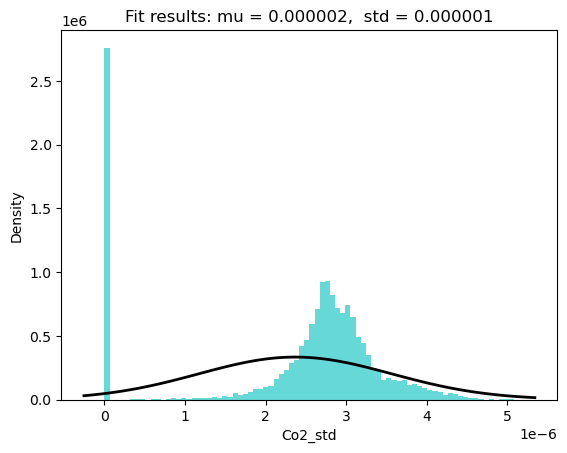

In [10]:
import matplotlib.pyplot as plt
hrange = (0.0, 5.087673589118194e-06)
mu, std = norm.fit(df_dim["co2_std"])
ahist=plt.hist(df_dim["co2_std"], bins=80, density=True, alpha=0.6, color='c', range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.6f,  std = %.6f" % (mu, std)
th=plt.title(title)
xh=plt.xlabel('Co2_std')
yh=plt.ylabel('Density')
# xl=plt.xlim(0,)
# yl=plt.ylim(-0.02, 0.45)

In [11]:
import plotly.express as px
fig = px.histogram(df_dim, x="co2_sdev", nbins=200, title="Histograma de co2_sdev")
fig.show()

## Basado en el segso observado en los graficos, optamos por eliminar valores donde co2_std -> 0

In [12]:
gdf2 = gdf.query("co2_std >= 0.000000001") #.plot(column='co2_std', cmap='OrRd', figsize=(15, 15), legend=True, scheme='quantiles')

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm


In [14]:
gdf2["co2_std"]

8        0.000003
91       0.000003
119      0.000004
144      0.000002
145      0.000002
           ...   
10939    0.000002
10940    0.000003
10941    0.000002
10942    0.000003
10943    0.000003
Name: co2_std, Length: 10803, dtype: float64

## Distribucion de datos despues de eliminar valores iguales o cercanos a 0                  

In [15]:
import plotly.express as px
fig = px.histogram(gdf2, x="co2_std", nbins=80, title="Histograma de co2_std")
fig.show()

In [16]:
import plotly.express as px
fig = px.histogram(gdf2, x="co2_sdev", nbins=200, title="Histograma de co2_sdev")
fig.show()

C:\Users\javoe\AppData\Local\Temp\ipykernel_30356\3664182266.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



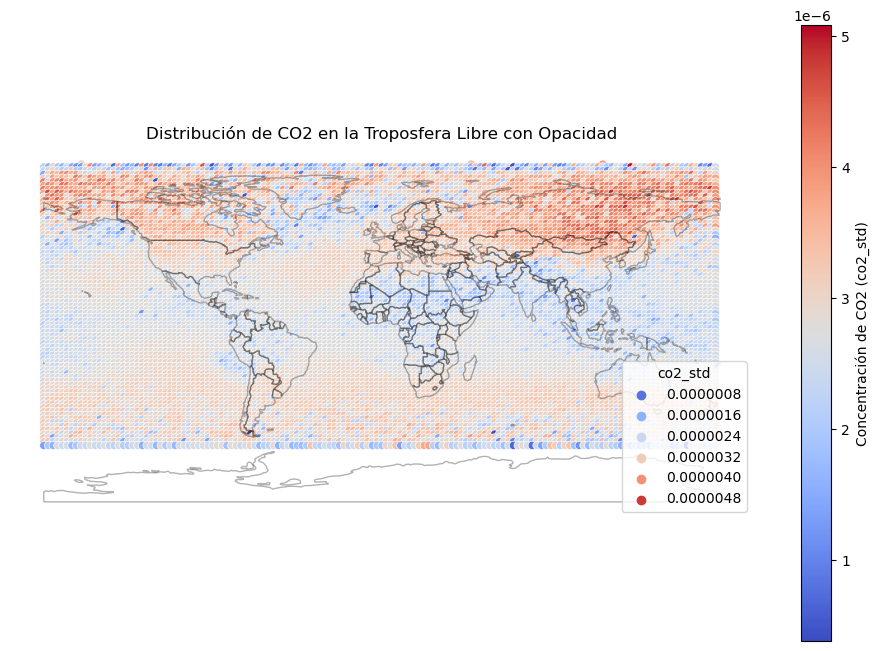

In [17]:

# Crea una figura de Matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Dibuja el mapa del mundo de GeoPandas como fondo
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, linewidth=1, color='black')

# Utiliza Seaborn para dibujar los puntos y personalizar la paleta de colores
sns.scatterplot(ax=ax,x= 'lon', y= 'lat', data = gdf2, hue = 'co2_std', palette='coolwarm')

# Agrega opacidad a los puntos para diferenciar la concentración
alpha = 0.3
ax.collections[0].set_alpha(alpha)

# Personaliza el aspecto del mapa
ax.set_title('Distribución de CO2 en la Troposfera Libre con Opacidad')
plt.axis('off')  # Desactiva los ejes

sm = cm.ScalarMappable(cmap='coolwarm')
sm.set_norm(mcolors.Normalize(vmin=min(gdf2["co2_std"]), vmax=max(gdf2["co2_std"])))
# Agrega una barra de colores (colorbar)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Concentración de CO2 (co2_std)')


# Muestra el mapa con los datos
plt.show()

C:\Users\javoe\AppData\Local\Temp\ipykernel_30356\1589977332.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



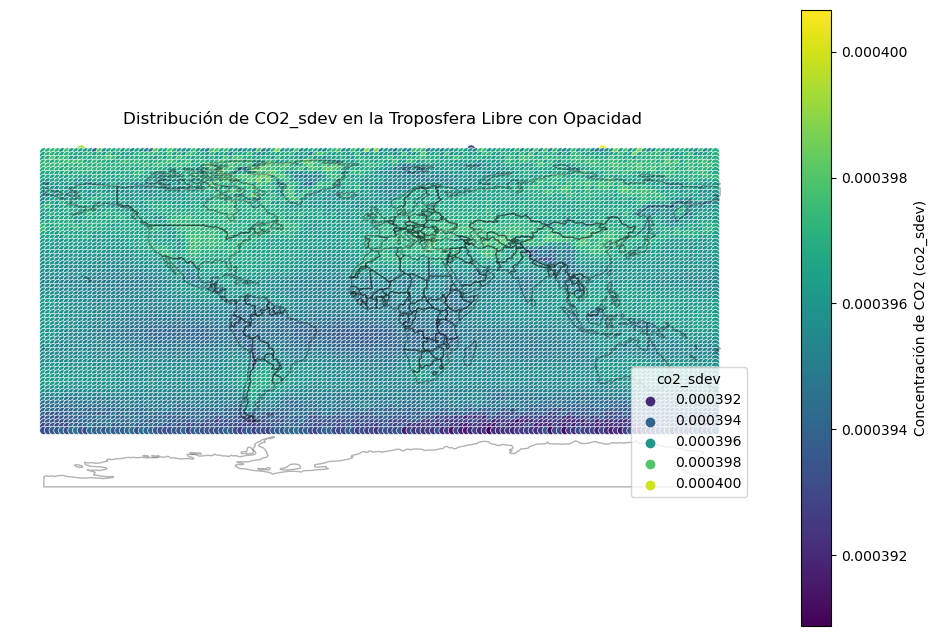

In [18]:
# Crea una figura de Matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Dibuja el mapa del mundo de GeoPandas como fondo
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, linewidth=1, color='black')

# Utiliza Seaborn para dibujar los puntos y personalizar la paleta de colores
sns.scatterplot(ax=ax,x= 'lon', y= 'lat', data = gdf2, hue = 'co2_sdev', palette='viridis')

# Agrega opacidad a los puntos para diferenciar la concentración
alpha = 0.3
ax.collections[0].set_alpha(alpha)

# Personaliza el aspecto del mapa
ax.set_title('Distribución de CO2_sdev en la Troposfera Libre con Opacidad')
plt.axis('off')  # Desactiva los ejes

sm = cm.ScalarMappable(cmap='viridis')
sm.set_norm(mcolors.Normalize(vmin=min(gdf2["co2_sdev"]), vmax=max(gdf2["co2_sdev"])))
# Agrega una barra de colores (colorbar)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Concentración de CO2 (co2_sdev)')


# Muestra el mapa con los datos
plt.show()

## Comprobar Normalidad

Comprobar si los datos siguen una distribución normal es importante en muchos análisis estadísticos, ya que varios métodos y pruebas estadísticas asumen o funcionan mejor cuando los datos se distribuyen normalmente. Para verificar la normalidad de los datos, se pueden utilizar diferentes métodos y pruebas estadísticas como la prueba de normalidad de Shapiro-Wilk, la prueba de Kolmogorov-Smirnov, histogramas, gráficos de probabilidad normal (QQ-plots) y otras herramientas visuales o estadísticas.

Al asegurarse de que los datos sigan una distribución normal, se puede tener más confianza en la aplicación de ciertos modelos estadísticos y en la interpretación de los resultados derivados de esos modelos.

c:\Users\javoe\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



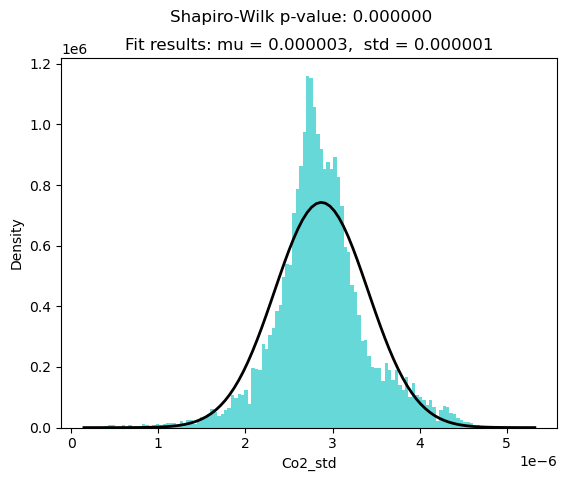

In [19]:
import matplotlib.pyplot as plt
hrange = (3.8129825927254777e-07, 5.087673589118194e-06)
mu, std = norm.fit(gdf2["co2_std"])
shapiro_test = shapiro(gdf2["co2_std"])
p_value = shapiro_test[1]  # El segundo valor retornado es el p-value de la prueba

ahist=plt.hist(gdf2["co2_std"], bins=120, density=True, alpha=0.6, color='c', range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.6f,  std = %.6f" % (mu, std)
subtitle = "Shapiro-Wilk p-value: %.6f" % p_value
th=plt.title(title)
sth=plt.suptitle(subtitle)
xh=plt.xlabel('Co2_std')
yh=plt.ylabel('Density')
# xl=plt.xlim(0,)
# yl=plt.ylim(-0.02, 0.45)

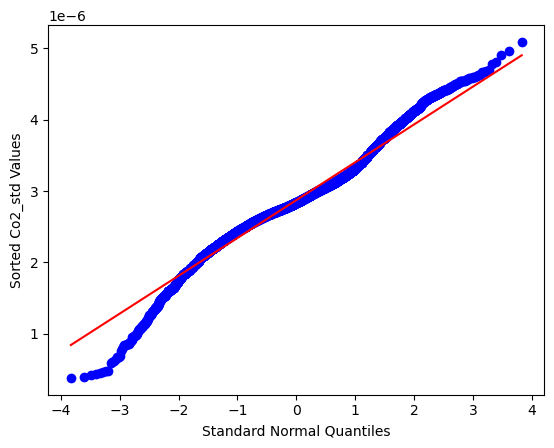

In [20]:
import scipy.stats as stats
qqdata = stats.probplot(gdf2["co2_std"], dist="norm", plot=plt, fit=True)
xh=plt.xlabel('Standard Normal Quantiles')
yh=plt.ylabel('Sorted Co2_std Values')
fig=plt.gcf()
th=plt.title('')

## Analisis de estacionariedad

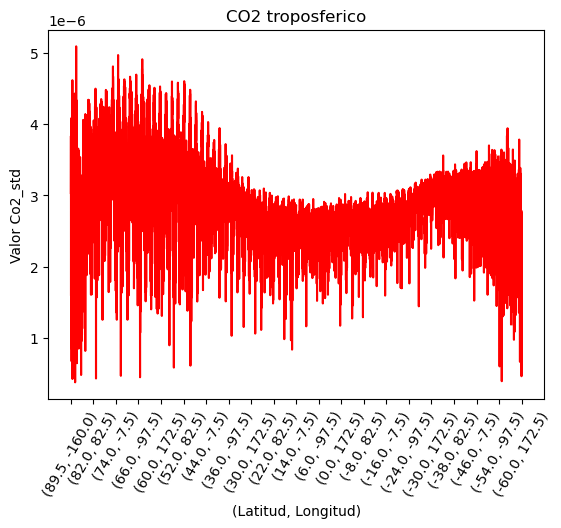

In [21]:
lati = gdf2["lat"]
loni = gdf2["lon"]
latlon = list(zip(lati, loni))
latlon = [str(x) for x in latlon]
fig,ax = plt.subplots()
plt.plot(latlon,gdf2["co2_std"],color='red')
plt.xticks(range(0,len(latlon),(round(len(latlon)/20))))
plt.xticks(rotation=60)
plt.xlabel("(Latitud, Longitud)")
plt.ylabel("Valor Co2_std")
plt.title("CO2 troposferico")
plt.show()

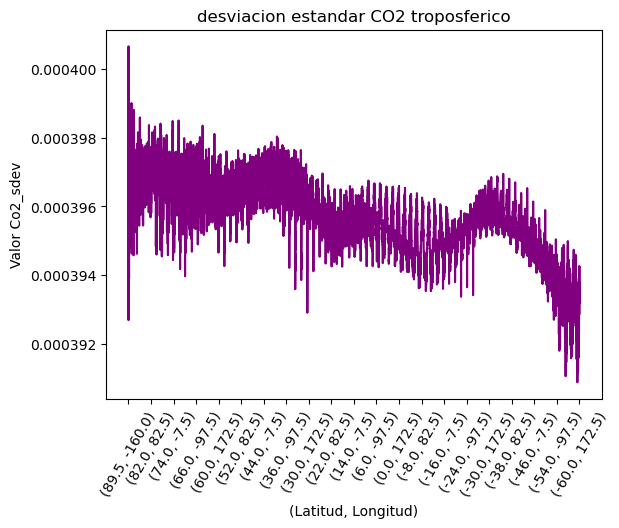

In [22]:
lati = gdf2["lat"]
loni = gdf2["lon"]
latlon = list(zip(lati, loni))
latlon = [str(x) for x in latlon]
fig,ax = plt.subplots()
plt.plot(latlon,gdf2["co2_sdev"],color='purple')
plt.xticks(range(0,len(latlon),(round(len(latlon)/20))))
plt.xticks(rotation=60)
plt.xlabel("(Latitud, Longitud)")
plt.ylabel("Valor Co2_sdev")
plt.title("desviacion estandar CO2 troposferico")
plt.show()

# Pruebas de estacionariedad

Para esto utilizaremos pruebas de raiz unitaria.
Una raíz unitaria es una característica de los procesos que evolucionan a través del tiempo y que puede causar problemas en inferencia estadística en modelos de series de tiempo.

Un proceso estocástico lineal tiene una raíz unitaria si el valor de la raíz de la ecuación característica del proceso es igual a 1, por lo tanto tal proceso es no estacionario. Si las demás raíces de la ecuación característica se encuentran dentro del círculo unitario es decir, tienen un valor absoluto menor a uno. entonces la primera diferencia del proceso es estacionaria.

---

## Algunas pruebas de raiz unitarias son:

### Argumented dickey fuller
La prueba de Dickey-Fuller aumentada es una prueba de hipótesis. La hipótesis nula es que la serie de tiempo no es estacionaria, y la alternativa es que la serie es estacionaria. Por lo tanto, necesitamos encontrar un valor p lo suficientemente bajo como para rechazar nuestra hipótesis nula, lo que sugiere que la serie es estacionaria.

### Phillips Perron
La prueba Phillips perron es una prueba de raiz unitaria basada en la prueba de dickey fuller y su misma hipotesis nula. y si el valor p es menor a la significanica rechazamos la hipotesis nula.

### Kwiatkowski Phillips Schmidt Shin
Contrariamente a la mayoría de las pruebas de raíz unitaria , la presencia de una raíz unitaria no es la hipótesis nula sino la alternativa. Además, en la prueba KPSS, la ausencia de una raíz unitaria no es una prueba de estacionariedad sino, por diseño, de estacionariedad debil. Esta es una distinción importante ya que es posible que una serie de tiempo no sea estacionaria, no tenga raíz unitaria pero sea debilmente estacionaria. por lo tanto si el valor p es menor a la significancia se dice que la serie es debilmente estacionaria.

### Dickey Fuller
La Prueba de Dickey-Fuller busca determinar la existencia o no de raíces unitarias en una serie de tiempo. La hipótesis nula de esta prueba es que existe una raíz unitaria en la serie.
El Modelos de regresión puede ser escrito como:

$$ \nabla y_{t}=(\rho-1)y_{t-1}+u_{t}=\delta y_{t-1}+u_{t} $$

Donde ∇ es el  operador de primera diferencia. Este modelo puede ser estimado y las pruebas para una raíz unitaria son equivalentes a pruebas δ = 0 (donde δ = ρ - 1). y al igual  que en la prueba aumentada para rechazar la hipotesis nula el valor p obtenido de la prueba debe ser menor a nuestra significancia.

In [23]:
# Librerias
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron,KPSS,DFGLS,ADF
from prettytable import PrettyTable

In [24]:
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
gdf2.columns

Index(['co2_std', 'co2_sdev', 'lat', 'lon', 'geometry'], dtype='object')

### Pruebas para CO2 Troposférico std

In [26]:
serie = gdf2.iloc[:,0]
adf = ADF(serie)
pp = PhillipsPerron(serie)
kpss = KPSS(serie)
df = DFGLS(serie)
x = PrettyTable()
x.field_names = ["Unitary root test","Test Statistic", "P-value", "Critical Value for 5%", "Alternative Hypothesis:"]
x.add_row(["Argumented Dickey Fuller", adf.stat, adf.pvalue, adf.critical_values["5%"], adf.alternative_hypothesis])
x.add_row(["Phillips Perron", pp.stat, pp.pvalue, pp.critical_values["5%"], pp.alternative_hypothesis])
x.add_row(["Kwiatkowski-Phillips-Schmidt-Shin", kpss.stat, kpss.pvalue, kpss.critical_values["5%"], kpss.alternative_hypothesis])
x.add_row(["Dickey-Fuller GLS", df.stat, df.pvalue, df.critical_values["5%"], df.alternative_hypothesis])
x


+-----------------------------------+---------------------+------------------------+-----------------------+-----------------------------------+
|         Unitary root test         |    Test Statistic   |        P-value         | Critical Value for 5% |      Alternative Hypothesis:      |
+-----------------------------------+---------------------+------------------------+-----------------------+-----------------------------------+
|      Argumented Dickey Fuller     |  -9.270589951673639 | 1.3301354155905225e-15 |  -2.8618085021011126  | The process is weakly stationary. |
|          Phillips Perron          | -101.07287313284044 |          0.0           |   -2.861807607138271  | The process is weakly stationary. |
| Kwiatkowski-Phillips-Schmidt-Shin |  3.5542876734971394 |         0.0001         |         0.4614        | The process contains a unit root. |
|         Dickey-Fuller GLS         |  -8.486833870023089 | 6.730213808923646e-14  |  -1.9456491396867541  | The process is weakly stationary. |
+-----------------------------------+---------------------+------------------------+-----------------------+-----------------------------------+

En resumen, las pruebas de Dickey-Fuller Aumentada, Phillips-Perron y Dickey-Fuller GLS indican que el proceso es débilmente estacionario, ya que los valores P son muy cercanos a cero, y los estadísticos de prueba están por debajo de los valores críticos.

Por otro lado, la prueba KPSS indica que el proceso contiene una unidad raíz, lo que significa que no es estacionario. Esto crea una discrepancia entre las pruebas, y en este caso, se daría preferencia a las pruebas de Dickey-Fuller Aumentada, Phillips-Perron y Dickey-Fuller GLS, que indican estacionariedad. Sin embargo, es importante considerar la interpretación en el contexto de los datos y los objetivos del análisis. Esta incertidumbre debido a la discrepancia en los resultados, nos motivan a considerar otras técnicas de análisis.

### Pruebas para la desviacion estandar del Co2

In [27]:
serie = gdf2.iloc[:,1]
adf = ADF(serie)
pp = PhillipsPerron(serie)
kpss = KPSS(serie)
df = DFGLS(serie)
x = PrettyTable()
x.field_names = ["Unitary root test","Test Statistic", "P-value", "Critical Value for 5%", "Alternative Hypothesis:"]
x.add_row(["Argumented Dickey Fuller", adf.stat, adf.pvalue, adf.critical_values["5%"], adf.alternative_hypothesis])
x.add_row(["Phillips Perron", pp.stat, pp.pvalue, pp.critical_values["5%"], pp.alternative_hypothesis])
x.add_row(["Kwiatkowski-Phillips-Schmidt-Shin", kpss.stat, kpss.pvalue, kpss.critical_values["5%"], kpss.alternative_hypothesis])
x.add_row(["Dickey-Fuller GLS", df.stat, df.pvalue, df.critical_values["5%"], df.alternative_hypothesis])
x

+-----------------------------------+---------------------+------------------------+-----------------------+-----------------------------------+
|         Unitary root test         |    Test Statistic   |        P-value         | Critical Value for 5% |      Alternative Hypothesis:      |
+-----------------------------------+---------------------+------------------------+-----------------------+-----------------------------------+
|      Argumented Dickey Fuller     |  -4.438444574330171 | 0.00025362816848594437 |  -2.8618085769516295  | The process is weakly stationary. |
|          Phillips Perron          |  -25.85341098192314 |          0.0           |   -2.861807607138271  | The process is weakly stationary. |
| Kwiatkowski-Phillips-Schmidt-Shin |  12.41554807175048  |         0.0001         |         0.4614        | The process contains a unit root. |
|         Dickey-Fuller GLS         | -0.7686066800042609 |   0.3939327633407807   |   -1.945649700954751  | The process is weakly stationary. |
+-----------------------------------+---------------------+------------------------+-----------------------+-----------------------------------+

En este caso, la Prueba de Dickey-Fuller Aumentada y la Prueba de Phillips-Perron indican que el proceso es débilmente estacionario, ya que los valores P son muy bajos, y los estadísticos de prueba están por debajo de los valores críticos. Estas pruebas respaldan la estacionariedad de los datos.

Por otro lado, la Prueba de Kwiatkowski-Phillips-Schmidt-Shin (KPSS) sugiere que el proceso contiene una unidad raíz, lo que significa que no es estacionario. Esta prueba está en contradicción con las otras dos pruebas.

La Prueba de Dickey-Fuller GLS no es tan concluyente, ya que el valor P es relativamente alto, y el estadístico de prueba no rechaza la hipótesis de no estacionariedad, pero tampoco la confirma con firmeza.

---

### En contexto 

Dado el contexto, es importante considerar que la estacionariedad de estas series temporales puede ser crucial en análisis geoestadísticos relacionados con el CO2 atmosférico, ya que las tendencias y patrones temporales pueden influir en la interpretación de los datos y en la toma de decisiones.

Las pruebas de raíz unitaria que has realizado indican que la Prueba de Dickey-Fuller Aumentada y la Prueba de Phillips-Perron sugieren que las series de datos "co2_std" y "co2_sdev" son débilmente estacionarias, lo que implica que pueden ser utilizadas en análisis estadísticos con la suposición de estacionariedad.

Por otro lado, la Prueba de Kwiatkowski-Phillips-Schmidt-Shin (KPSS) sugiere que las series de datos contienen una unidad raíz, lo que implicaría no estacionariedad. Esta discrepancia entre las pruebas podría deberse a diferentes supuestos y enfoques de las pruebas.

En esta situación, consideramos las siguientes opciones:

Evaluar visualmente los datos: Realiza gráficos de las series temporales para identificar tendencias, estacionalidades u otros patrones visuales que puedan ayudarte a tomar una decisión más informada sobre la estacionariedad.

Realizar más pruebas: Podrías considerar realizar pruebas adicionales o explorar técnicas estadísticas más avanzadas para evaluar la estacionariedad de las series de datos.

Diferenciación: Si no puedes llegar a una conclusión clara sobre la estacionariedad de las series de datos, podrías aplicar técnicas de diferenciación para transformar los datos y hacerlos estacionarios antes de continuar con tu análisis geoestadístico.

Logaritmos: En nuestro caso particular y debido que los valores son pequeños, aplicar logaritmos aún puede ser una estrategia útil para estabilizar la varianza y reducir la magnitud de las fluctuaciones en la serie temporal. Sin embargo, es importante tener en cuenta que, en este caso, el logaritmo natural (ln) puede ser más apropiado, ya que tiende a funcionar mejor con valores pequeños. Como datos son muy pequeños, es probable que tengan una magnitud similar a la de los valores logaritmicos resultantes. Esto puede facilitar la interpretación de los resultados y hacer que los datos transformados sean más adecuados para análisis groestadísticos, incluyendo pruebas de estacionariedad.


---

# Determinar distancia optima de lag

Determinar la distancia óptima de "lag" es importante porque impacta directamente en la estimación de la variabilidad espacial y en la interpolación de valores en ubicaciones no muestreadas. Un "lag" demasiado pequeño puede no capturar la verdadera estructura espacial de los datos, mientras que un "lag" demasiado grande puede perder detalles importantes.

El uso de la función scattergram() ayuda a visualizar cómo cambian las diferencias entre los valores de los pares de puntos a medida que aumenta la distancia entre ellos. Esto puede proporcionar pistas sobre la estructura de correlación espacial y ayudar a identificar la distancia óptima de "lag" donde se alcanza un equilibrio entre la autocorrelación y la variabilidad espacial.

---

Para determinar el "lag" adecuado de un semivariograma, es importante considerar la naturaleza de tus datos y la distribución espacial de las observaciones. El "lag" se refiere a la distancia entre pares de puntos a lo largo de la cual se calcula la semivarianza para construir el semivariograma.

Basado en el contexto proporcionado, donde los archivos están distribuidos en cuadrículas de 2 grados de latitud por 2.5 grados de longitud, consideraremos estas medidas como una referencia para definir el lag y la distancia del semivariograma:

Lag (h): El lag puede interpretarse como la distancia entre los centroides de las cuadrículas. Dado que los datos están en cuadrículas de 2 grados de latitud por 2.5 grados de longitud Inicialmente proprobaremos con valores de lag de 2 grados (para la dirección de latitud) y 2.5 grados (para la dirección de longitud) para representar la distancia entre las cuadrículas vecinas.

Distancia: Dado que estamos trabajando con datos en cuadrículas, la distancia puede interpretarse como la distancia geográfica entre los centroides de las cuadrículas vecinas. Dependiendo del tipo de análisis que ser realice, probaremos igualmente con valores de distancia de 2 grados (latitud) y 2.5 grados (longitud) para representar la separación entre las cuadrículas adyacentes.

Estos valores de lag y distancia se alinean con las dimensiones de las cuadrículas utilizadas en la creación de los productos L3 CO2 estándar y podrían ser un buen punto de partida para realizar un análisis de variograma sobre estos datos gridded. Notar que estos valores son iniciales y podrían necesitar ajustes según los patrones de variabilidad observados en los datos. Es posible que experimentar con diferentes valores para encontrar el lag y la distancia óptimos que revelen la estructura de correlación espacial de los datos.

In [28]:
gdf2[['co2_std',"lat","lon"]].describe()

co2_std           lat           lon
count  1.080300e+04  10803.000000  10803.000000
mean   2.871539e-06     14.020966     -1.249190
std    5.369444e-07     43.311687    103.929486
min    3.812983e-07    -60.000000   -180.000000
25%    2.588932e-06    -24.000000    -91.250000
50%    2.836733e-06     14.000000      0.000000
75%    3.130409e-06     52.000000     88.750000
max    5.087674e-06     89.500000    177.500000

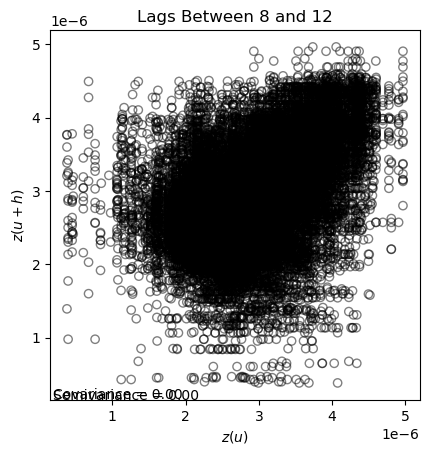

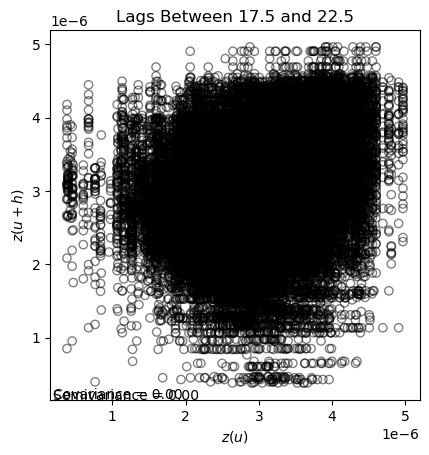

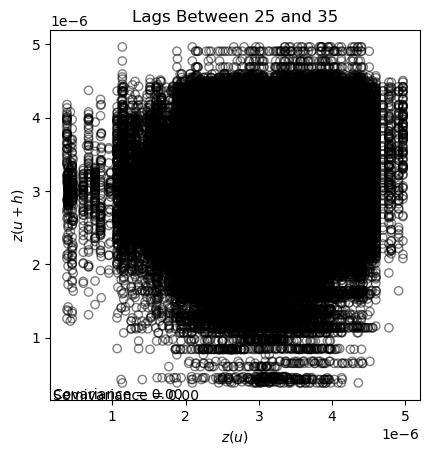

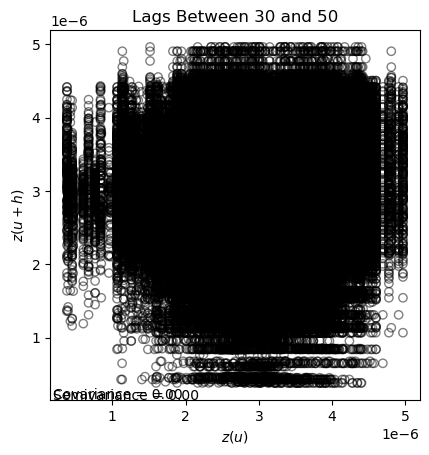

In [73]:
import numpy as np
import pandas as pd
from geostatsmodels import utilities, variograms, model, kriging, geoplot


# muestra tamano 1000
muestra = gdf2.sample(n=5000)

P = np.array(muestra[["lat","lon",'co2_std']])
pw = utilities.pairwise(P)
geoplot.hscattergram(P,pw,10,2)
geoplot.hscattergram(P,pw,20,2.5)
geoplot.hscattergram(P,pw,30,5)
geoplot.hscattergram(P,pw,40,10)

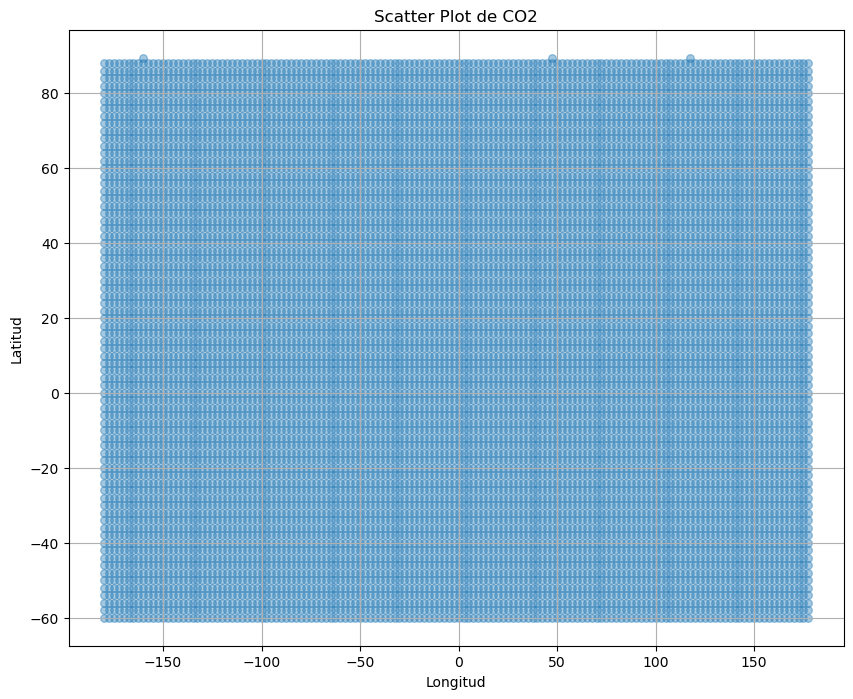

In [30]:
import matplotlib.pyplot as plt

# Supongamos que gdf2 contiene tus datos con columnas lat, lon, y co2_std

# Crear un scatter plot con transparencia
plt.figure(figsize=(10, 8))
plt.scatter(gdf2['lon'], gdf2['lat'], s=30, alpha=0.4)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Scatter Plot de CO2')
plt.grid(True)
plt.show()

## Semivariograma

En el contexto del análisis geoestadístico, el semivariograma es una herramienta crucial que muestra la variabilidad espacial de los datos a medida que la distancia entre las observaciones cambia. El "sill" se refiere a un valor constante en el semivariograma que indica la máxima variabilidad espacial entre los datos. Visualmente, en un gráfico de semivariograma, el sill puede representarse como una línea horizontal en el punto donde la variabilidad entre las muestras ya no cambia, lo que indica la máxima distancia a la que las muestras están correlacionadas espacialmente.

In [68]:
pd.DataFrame(P.tolist(), columns=["lat", "lon", "co2_std"]).describe()

lat          lon       co2_std
count  5000.000000  5000.000000  5.000000e+03
mean     14.020100    -2.753000  2.875804e-06
std      43.383317   104.648692  5.283381e-07
min     -60.000000  -180.000000  3.812983e-07
25%     -24.000000   -95.000000  2.593777e-06
50%      14.000000    -2.500000  2.842258e-06
75%      52.000000    87.500000  3.132290e-06
max      89.500000   177.500000  4.965496e-06

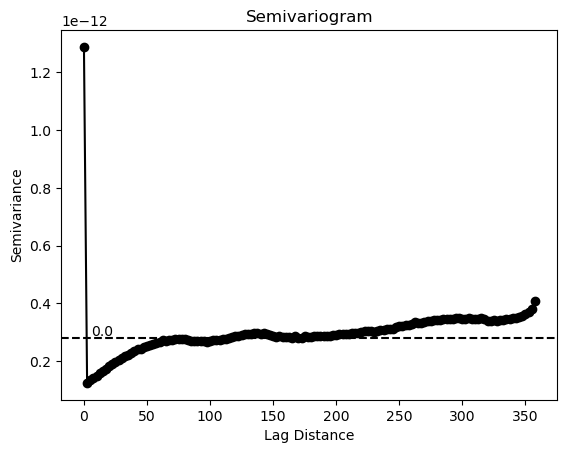

In [69]:
latgrad = 2
longrad = 2.5
lags = np.arange(0, 360, longrad)
sill = np.var(P[:, 2])

geoplot.semivariogram(P, lags, latgrad)

In [70]:
print(P.shape,lags.shape)

(5000, 3) (144,)


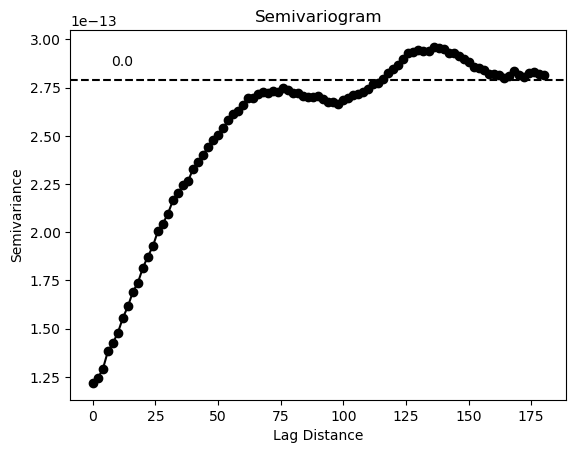

In [71]:

lags = np.arange(0, 182, latgrad)
sill = np.var(P[:, 2])
geoplot.semivariogram(P, lags, longrad)

In [72]:
print(P.shape,lags.shape)

(5000, 3) (91,)


## decision de lag y distancia

- lag: 5
- distacia: 10 (1000km +- 250)

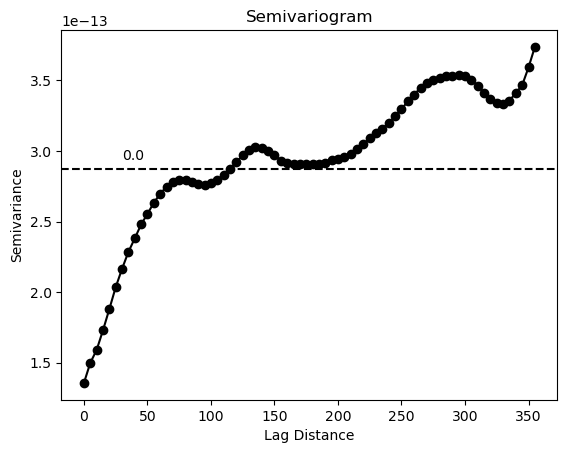

In [74]:

lags = np.arange(0,360, 5)
sill = np.var(P[:, 2])
geoplot.semivariogram(P, lags, 10)

# Variograma

In [90]:
P[:,:2]
pd.DataFrame(P[:,:2]).describe() 

0            1
count  5000.000000  5000.000000
mean     13.520700    -0.727000
std      43.100574   104.287939
min     -60.000000  -180.000000
25%     -24.000000   -90.000000
50%      14.000000     0.000000
75%      50.000000    90.000000
max      89.500000   177.500000

In [119]:
import skgstat as skg
import matplotlib.pyplot as plt

lag = [2,2.5,5,10]
model = ["spherical","exponential","gaussian","matern"]
# create a variogram instance
v1 = skg.Variogram(P[:,:2], P[:,2], normalize=False, model=model[0], n_lags=30)


In [120]:
v2 = skg.Variogram(P[:,:2], P[:,2], normalize=True, model=model[1], n_lags=30)
v3 = skg.Variogram(P[:,:2], P[:,2], normalize=False, model=model[2], n_lags=30)

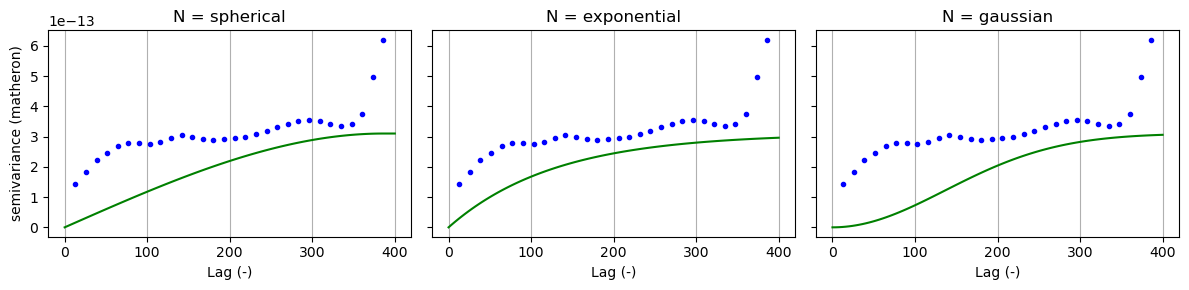

In [121]:
fig, _a = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
axes = _a.flatten()

x = np.linspace(0, 400, 100)

# plot each variogram
for i, v in enumerate([v1, v2, v3]):
    axes[i].plot(v.bins, v.experimental, '.b')
    axes[i].plot(x, v.fitted_model(x), '-g')
    axes[i].set_title(f'N = {model[i]}')
    axes[i].set_xlabel('Lag (-)')
    if i == 0:
        axes[0].set_ylabel('semivariance (matheron)')
    axes[i].grid(which='major', axis='x')
plt.tight_layout()

In [102]:
v1.rmse

1.1333435075708223e-13

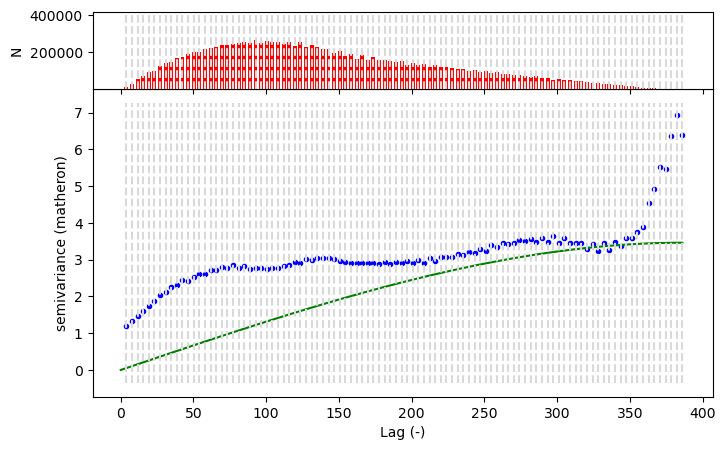

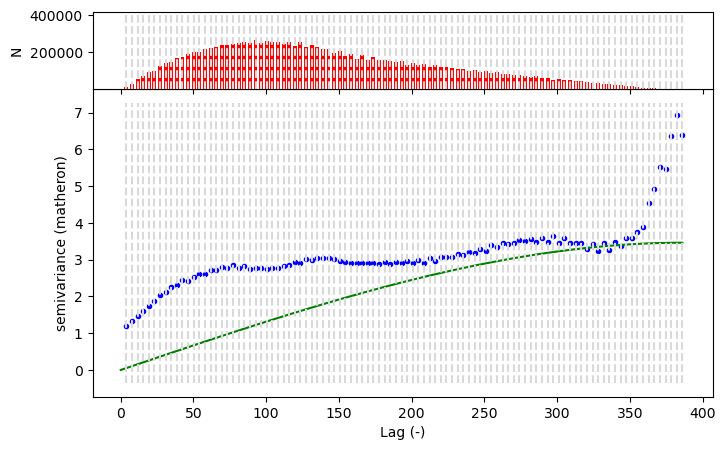

In [106]:
v1.plot(show=False)